In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle

In [2]:
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
# project_root = notebook_dir
os.chdir(project_root)


In [3]:
# from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 

/opt/conda/envs/haize/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [4]:
import torch
tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.pt")
NEED_TO_FLIP = True # cursor told me I didn't have to flip, but if I don't, the probe results suck
if NEED_TO_FLIP:
    activations_start = tensors_loaded['data'].reshape(28, 4198, 3072)
    activations = torch.transpose(activations_start, 0, 1)
else:
    activations = tensors_loaded['data'].reshape(4198, 28, 3072)

ADD_MEAN_LAYER = True
if ADD_MEAN_LAYER:
    # Calculate mean over layers dimension (dim=1, keepdim=True)
    mean_layer = torch.mean(activations, dim=1, keepdim=True)  

    # Concatenate mean layer to original activations
    activations_with_mean = torch.cat([activations, mean_layer], dim=1)  # New shape: (n_samples, n_layers+1, n_vector_length)
    assert (activations_with_mean[:, 5, :] == activations[:, 5, :]).all()
    activations = activations_with_mean


labels = tensors_loaded['labels']

n_layers = activations.shape[1]
n_samples = activations.shape[0]
n_vector_length = activations.shape[2]
activations.shape, labels.shape

/var/tmp/ipykernel_26151/4195644785.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instr

(torch.Size([4198, 29, 3072]), torch.Size([117544]))

In [5]:
import pandas as pd
df = pd.read_csv("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.csv")

In [6]:
def train_test_split_activations(activations, labels):
    assert len(df) == len(activations)
    idx = range(len(df))
    # Randomly shuffle indices
    np.random.seed(42)
    shuffled_idx = np.random.permutation(idx)

    # Split into train/test sets (80/20 split)
    train_idx = shuffled_idx[:int(0.8 * len(idx))]
    test_idx = shuffled_idx[int(0.8 * len(idx)):]

    # Select train/test data using indices
    train_activations = activations[train_idx]
    test_activations = activations[test_idx]
    train_labels = labels[train_idx] 
    test_labels = labels[test_idx]
    return train_activations, train_labels, test_activations, test_labels

train_activations, train_labels, test_activations, test_labels =train_test_split_activations(activations, labels)




In [7]:
layer_train, layer_test = -1, -1
log_model, train_accuracy, accuracy= create_logistic_regression_model(train_activations[:,layer_train,:], train_labels, test_activations[:,layer_test,:], test_labels)
print("Train accuracy: ", train_accuracy, "Test accuracy: ", accuracy)

Train accuracy:  0.9291244788564622 Test accuracy:  0.8321428571428572


In [13]:
import tqdm
save_id = 2
fname_save_template = "datasets/layer_transfer/logistic_regression_layer_accuracies_{save_id}.csv"
test_accuracies = -1*np.ones((n_layers,n_layers))
train_accuracies = -1*np.ones(n_layers)
for layer_train in tqdm.tqdm(range(n_layers)):
    for layer_test in range(n_layers):
        # print(f"Running layer_train: {layer_train}, layer_test: {layer_test}")
        log_model, train_accuracy, test_accuracy= create_logistic_regression_model(train_activations[:,layer_train,:], train_labels, test_activations[:,layer_test,:], test_labels)
        test_accuracies[layer_train,layer_test] = test_accuracy
        train_accuracies[layer_train] = train_accuracy
np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies, delimiter=",")
test_accuracies


100%|██████████| 29/29 [11:39<00:00, 24.11s/it]


array([[0.74404762, 0.74047619, 0.725     , 0.725     , 0.69404762,
        0.67619048, 0.64404762, 0.63928571, 0.64166667, 0.63333333,
        0.60119048, 0.59404762, 0.56071429, 0.57261905, 0.55952381,
        0.56071429, 0.59404762, 0.59642857, 0.58928571, 0.5702381 ,
        0.55833333, 0.52142857, 0.55714286, 0.56666667, 0.59285714,
        0.58333333, 0.55357143, 0.57142857, 0.56904762],
       [0.65      , 0.775     , 0.75      , 0.7297619 , 0.71785714,
        0.6       , 0.59166667, 0.59404762, 0.51190476, 0.575     ,
        0.55952381, 0.56190476, 0.59285714, 0.64285714, 0.60238095,
        0.58809524, 0.64285714, 0.62261905, 0.58333333, 0.56904762,
        0.60833333, 0.58690476, 0.59285714, 0.61071429, 0.60952381,
        0.58333333, 0.60833333, 0.55357143, 0.62380952],
       [0.56309524, 0.71666667, 0.79285714, 0.77619048, 0.70357143,
        0.62380952, 0.65595238, 0.60119048, 0.61071429, 0.58690476,
        0.6       , 0.57738095, 0.6047619 , 0.57857143, 0.53928571,
  

In [14]:
if True:
    l_test_accuracies = []
    for save_id in [0,1,2]:
        test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
        l_test_accuracies.append(test_accuracies_i)

    test_accuracies_mean = np.mean(l_test_accuracies, axis=0)



In [10]:
if True:
    test_accuracies2  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    (test_accuracies2 == test_accuracies).all()

np.True_

In [ ]:
# test_accuracies_for_plot = test_accuracies
# test_accuracies_for_plot = test_accuracies2
test_accuracies_for_plot = test_accuracies_mean


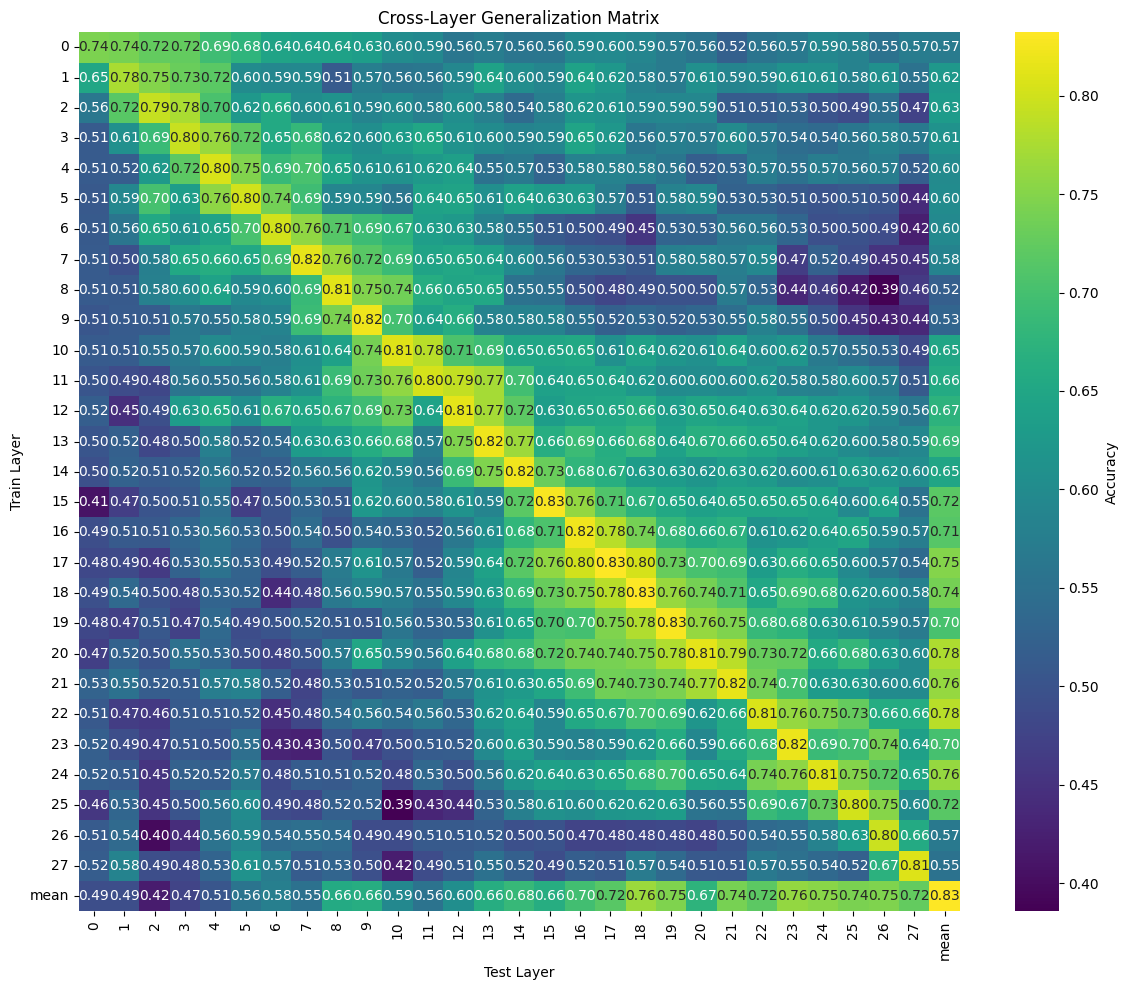

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with larger size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(test_accuracies_for_plot, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format numbers to 2 decimal places
            cmap='viridis',  # Color scheme
            xticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on x-axis
            yticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on y-axis
            cbar_kws={'label': 'Accuracy'})  # Colorbar label

# Add labels and title
plt.xlabel('Test Layer')
plt.ylabel('Train Layer')
plt.title(f'Cross-Layer Generalization Matrix')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot if needed
# save_path = project_root / f"datasets/layer_transfer/cross_layer_generalization.pdf"
# save_path.parent.mkdir(parents=True, exist_ok=True)
save_path = "datasets/layer_transfer/cross_layer_generalization.pdf"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()